In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("online_retail.csv")
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


### Data Cleaning 

In [2]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [3]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# df['Customer ID'] = df['Customer ID'].astype(float)
df['Invoice'] = df['Invoice'].astype(str)

In [5]:
null_cusID_rows = df[df['Customer ID'].isnull()]
num_null_cusID_rows = len(null_cusID_rows)
num_null_cusID_rows

total_rows = len(df)
percentage_null_cusID = (num_null_cusID_rows / total_rows) * 100
print(f"Percentage of rows with null customer ID: {percentage_null_cusID:.2f}%")

Percentage of rows with null customer ID: 22.77%


In [6]:
# df = df[df['Quantity'] >= 1]
# df = df[df['Price'] >= 1]

In [7]:
df['UnitPrice'] = df['Price']

In [8]:
df = df.drop(['Price'], axis = 1)

In [9]:
df['TotalPrice'] = (df['Quantity'] * df['UnitPrice']).round(2)

In [10]:
df['Customer_ID'] = df['Customer ID']
df = df.drop(['Customer ID'], axis = 1)

In [11]:
df.replace("", pd.NA, inplace=True)

In [12]:
df.drop(labels = 429103, inplace = True, axis = 0)

##### Customer_analysis on registered customers & sales analysis on all data

In [13]:
registerd_cus = df[df['Customer_ID'].notnull()]
guest_cus = df[df['Customer_ID'].isnull()]

df['Customer_ID'] = df['Customer_ID'].fillna("Guest")

In [14]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Country                object
UnitPrice             float64
TotalPrice            float64
Customer_ID            object
dtype: object

In [15]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,TotalPrice
count,1.067370e+06,1067370,1.067370e+06,1.067370e+06
mean,9.938975e+00,2011-01-02 21:14:00.349025792,4.649392e+00,1.806988e+01
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,-1.684696e+05
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,3.750000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,9.900000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,1.770000e+01
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,1.684696e+05
std,1.727059e+02,NaN,1.235531e+02,2.924204e+02


In [16]:
df.to_csv("Cleaned_df.csv", index=False)
registerd_cus.to_csv("Customer_data.csv", index = False)
guest_cus.to_csv("guest_cus.csv", index= False)

In [17]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Country                object
UnitPrice             float64
TotalPrice            float64
Customer_ID            object
dtype: object

In [18]:
df = pd.read_csv("Cleaned_df.csv")
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Country', 'UnitPrice', 'TotalPrice', 'Customer_ID'],
      dtype='object')

### Connecting Python🐍 to PostgreSQL

In [19]:
from sqlalchemy import create_engine

host = "localhost"
port = "5432"
database = "ecommerce_retail"
user = "postgres"
password = "postgre!safe"

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")

In [20]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Country', 'UnitPrice', 'TotalPrice', 'Customer_ID'],
      dtype='object')

#### Registerd and un-registered Customers

In [21]:
query = """
SELECT
    COUNT(*) as total_rows,
    COUNT(Customer_ID) FILTER (WHERE Customer_ID != 'Guest') AS with_customer_id, 
    COUNT(*) FILTER (WHERE Customer_ID = 'Guest') AS guest_cus_ID
FROM sales_retail;
"""

cus_type_count = pd.read_sql_query(query, engine)
cus_type_count

,total_rows,with_customer_id,guest_cus_id
0,1067370,824364,243006


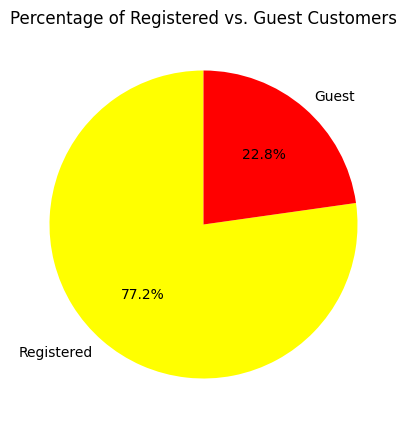

In [22]:
plt.figure(figsize=(5, 5))
labels = ['Registered', 'Guest']
sizes = [cus_type_count['with_customer_id'][0], cus_type_count['guest_cus_id'][0]]
colors = ['yellow', 'red']
plt.pie(sizes, colors= colors ,labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Registered vs. Guest Customers')
plt.show()

C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_8280\2487167852.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['Registered', 'Guest'], y = [cus_type_count['with_customer_id'][0], cus_type_count['guest_cus_id'][0]], palette = 'pastel')


<Axes: >

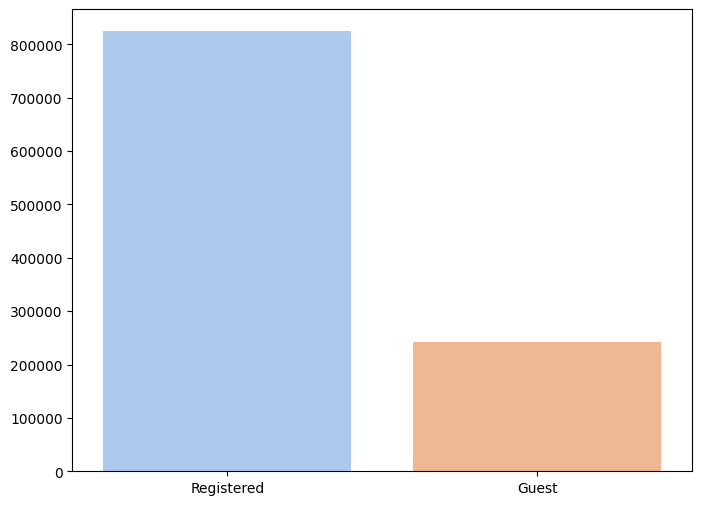

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(x = ['Registered', 'Guest'], y = [cus_type_count['with_customer_id'][0], cus_type_count['guest_cus_id'][0]], palette = 'pastel')


#### Total Revenue

In [24]:
query = """
SELECT SUM(TotalPrice) AS total_revenue FROM sales_retail;
"""

print("💰 Total Revenue:")
pd.read_sql(query, engine)

💰 Total Revenue:


,total_revenue
0,19291002.0


#### Distinct products

In [25]:
query = """
SELECT 
    COUNT (DISTINCT Description) AS distinct_products
FROM sales_retail 
"""

pd.read_sql_query(query, engine)

,distinct_products
0,5698


#### Top 10 Selling products

In [26]:
query = """
SELECT Description, SUM(Quantity) as total_quantity
FROM sales_retail
GROUP BY Description
ORDER BY total_quantity DESC
LIMIT 10"""

top_10 = pd.read_sql_query(query, engine)
top_10

,description,total_quantity
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,108545
1,WHITE HANGING HEART T-LIGHT HOLDER,93050
2,ASSORTED COLOUR BIRD ORNAMENT,81306
3,JUMBO BAG RED RETROSPOT,78090
4,BROCADE RING PURSE,70700
5,PACK OF 60 PINK PAISLEY CAKE CASES,56575
6,60 TEATIME FAIRY CAKE CASES,54366
7,SMALL POPCORN HOLDER,49616
8,PACK OF 72 RETROSPOT CAKE CASES,49344
9,PACK OF 72 RETRO SPOT CAKE CASES,46106


<Axes: xlabel='total_quantity', ylabel='description'>

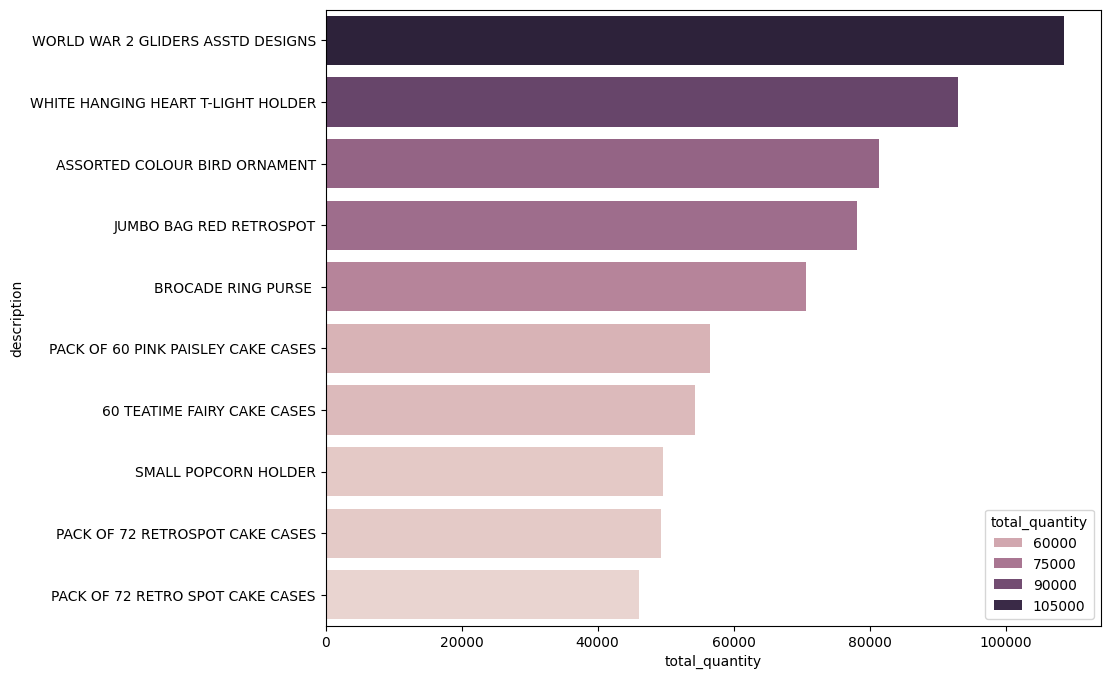

In [27]:
plt.figure(figsize=(10,8))
sns.barplot(x = top_10['total_quantity'], y = top_10['description'], hue = top_10['total_quantity'])

#### Revenue by month

In [102]:
query = """
SELECT DATE_TRUNC('month', InvoiceDate) AS month,
DATE_TRUNC('day', InvoiceDate) AS day,
SUM(TotalPrice) AS total_revenue
FROM sales_retail
GROUP BY month, day
ORDER BY month DESC; 
"""

revenueByMonth = pd.read_sql_query(query, engine)
revenueByMonth

,month,day,total_revenue
0,2011-12-01 00:00:00-05:00,2011-12-01 00:00:00-05:00,51410.953
1,2011-12-01 00:00:00-05:00,2011-12-02 00:00:00-05:00,57086.105
2,2011-12-01 00:00:00-05:00,2011-12-04 00:00:00-05:00,24565.785
3,2011-12-01 00:00:00-05:00,2011-12-05 00:00:00-05:00,57751.508
4,2011-12-01 00:00:00-05:00,2011-12-06 00:00:00-05:00,54228.383
...,...,...,...
599,2009-12-01 00:00:00-05:00,2009-12-18 00:00:00-05:00,42371.004
600,2009-12-01 00:00:00-05:00,2009-12-20 00:00:00-05:00,11335.237
601,2009-12-01 00:00:00-05:00,2009-12-21 00:00:00-05:00,14576.080
602,2009-12-01 00:00:00-05:00,2009-12-22 00:00:00-05:00,27481.668


C:\Users\M Khubaib Ahmad\AppData\Local\Temp\ipykernel_8280\1150640195.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(revenueByMonth['day'], rotation=45)


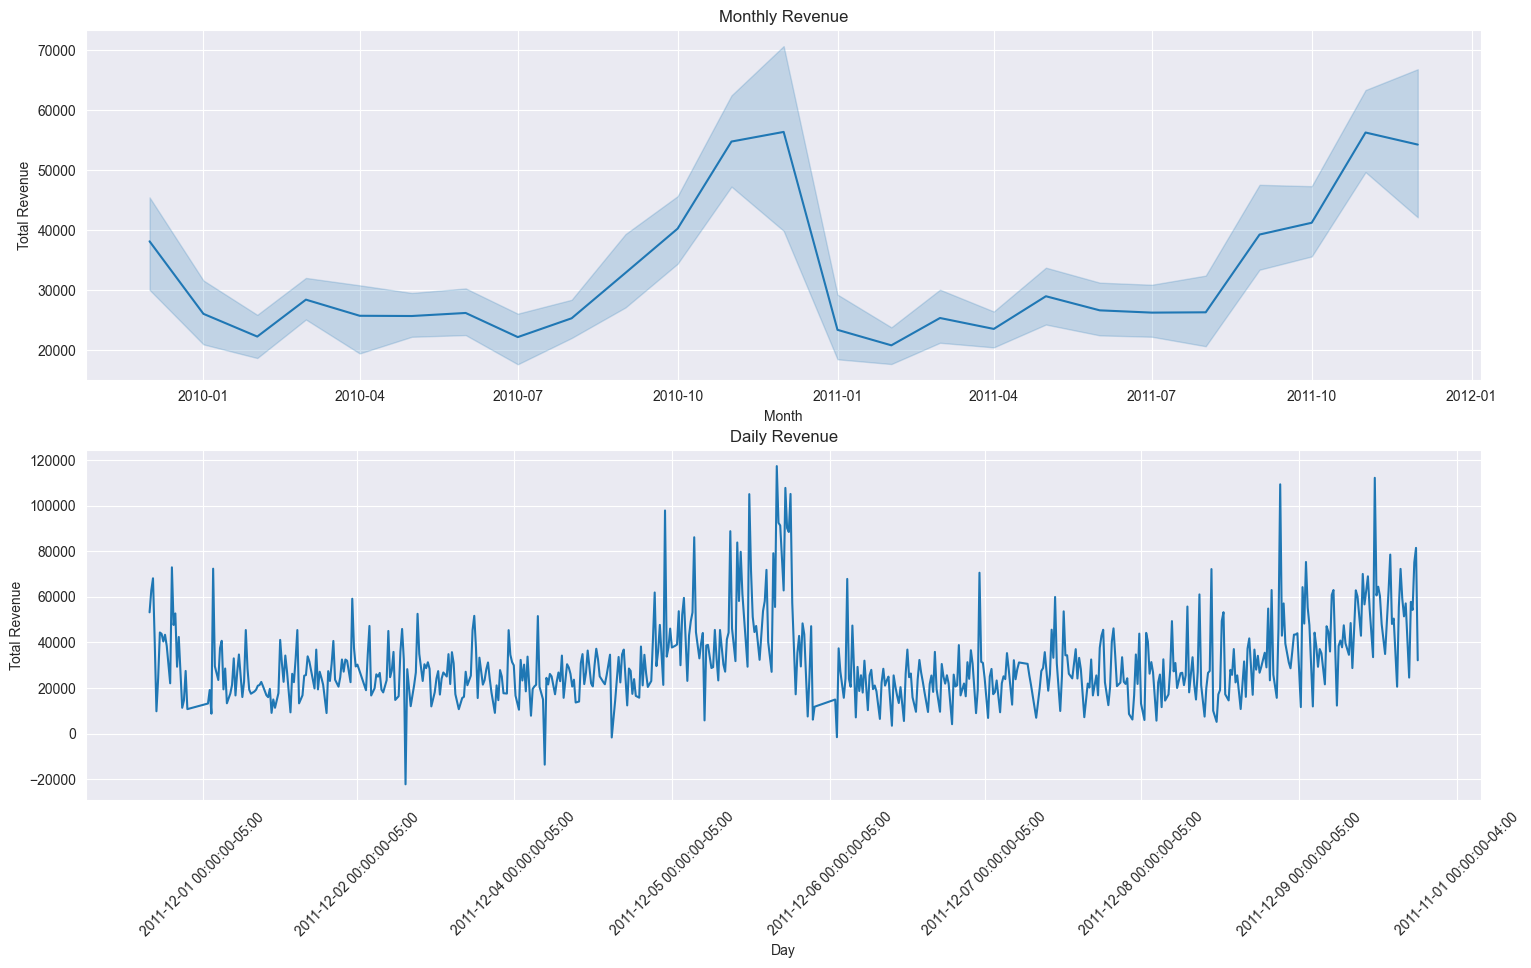

In [113]:
fig, axes = plt.subplots(2, 1, figsize=(18,10))
sns.lineplot(x = revenueByMonth['month'], y = revenueByMonth['total_revenue'], ax = axes[0])
axes[0].set_title('Monthly Revenue')
axes[0].set_xlabel('Month')
axes[0].set_ylabel("Total Revenue")
# axes[0].set_style("darkgrid")

sns.lineplot(x = revenueByMonth['day'], y = revenueByMonth['total_revenue'], ax = axes[1])
axes[1].set_title('Daily Revenue')
axes[1].set_xlabel('Day')
axes[1].set_ylabel("Total Revenue")
axes[1].set_xticklabels(revenueByMonth['day'], rotation=45)
# axes[1].set_style("darkgrid")

engine.dispose()

#### Countrywise revenue

In [75]:
query = """
SELECT Country, SUM(TotalPrice) AS country_revenue
FROM sales_retail
GROUP BY Country
ORDER BY country_revenue DESC
LIMIT 10
"""

country_revenue = pd.read_sql_query(query, engine)
country_revenue

,country,country_revenue
0,United Kingdom,1.638903e+07
1,EIRE,6.155226e+05
2,Netherlands,5.485256e+05
3,Germany,4.179880e+05
4,France,3.281915e+05
5,Australia,1.671291e+05
6,Switzerland,9.972868e+04
7,Spain,9.185934e+04
8,Sweden,8.780945e+04
9,Denmark,6.574109e+04


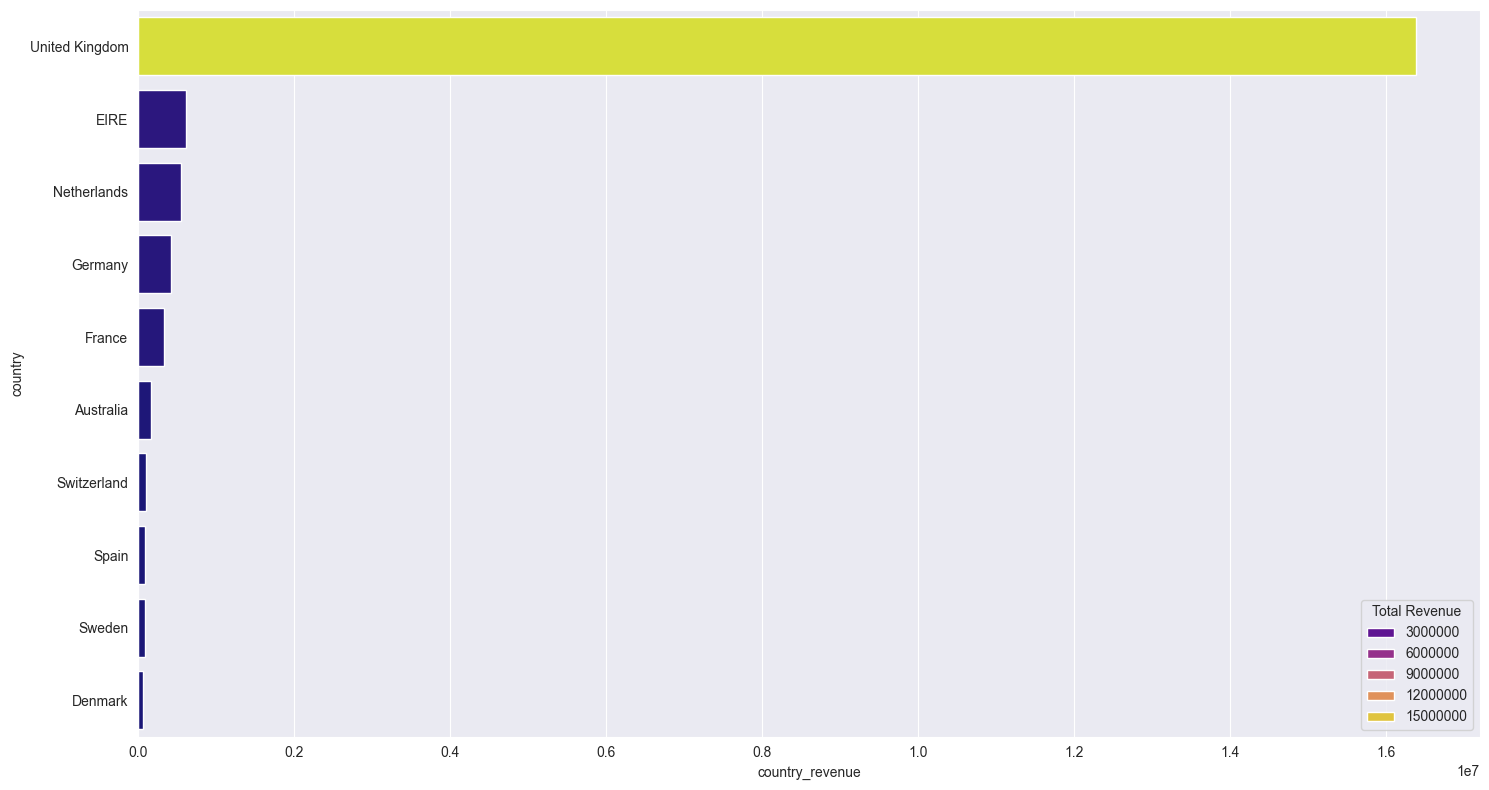

In [89]:
plt.figure(figsize=(15,8))
sns.barplot(x=country_revenue['country_revenue'], y=country_revenue['country'], hue = country_revenue['country_revenue'], palette='plasma')
plt.tight_layout()
plt.legend(title='Total Revenue', loc='lower right')
plt.show()

#### Top 10 Customers with most revenue & orders

In [47]:
query = """
SELECT 
Customer_ID,
COUNT(DISTINCT Invoice) AS total_orders,
COUNT(DISTINCT Description) AS total_products,
SUM(TotalPrice) AS total_spent
FROM sales_retail
WHERE Customer_ID != 'Guest'
GROUP BY Customer_ID
ORDER BY total_spent DESC
LIMIT 15
"""

most_revenue_cus = pd.read_sql_query(query, engine)
most_revenue_cus

,customer_id,total_orders,total_products,total_spent
0,18102.0,153,415,598215.000
1,14646.0,164,1058,523342.200
2,14156.0,202,1573,296565.470
3,14911.0,510,2754,270251.620
4,17450.0,61,163,233579.390
5,13694.0,164,933,190825.250
6,17511.0,85,763,171885.800
7,12415.0,33,520,143269.140
8,16684.0,65,204,141502.310
9,15061.0,138,147,136391.520


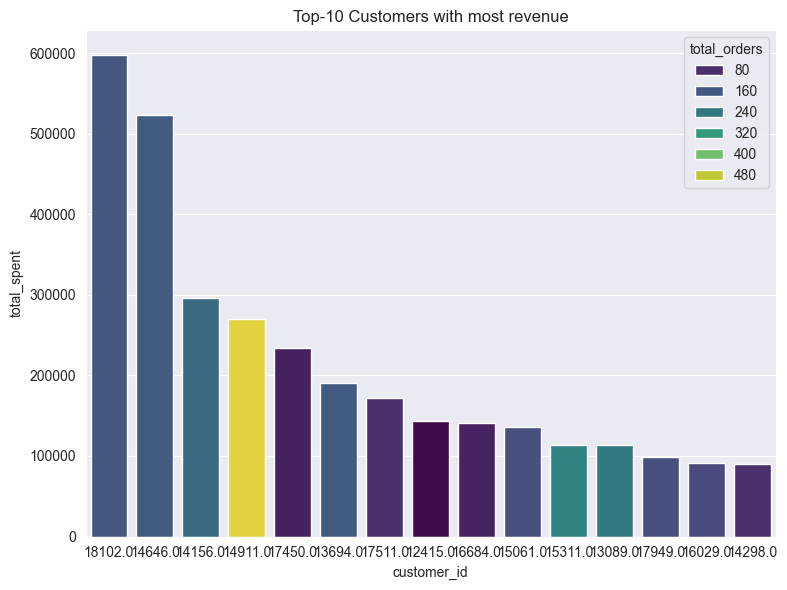

In [48]:
plt.figure(figsize=(8,6))
sns.barplot(x = most_revenue_cus['customer_id'], y = most_revenue_cus['total_spent'], hue = most_revenue_cus['total_orders'], palette='viridis')
plt.title("Top-10 Customers with most revenue")
plt.tight_layout()
plt.show()

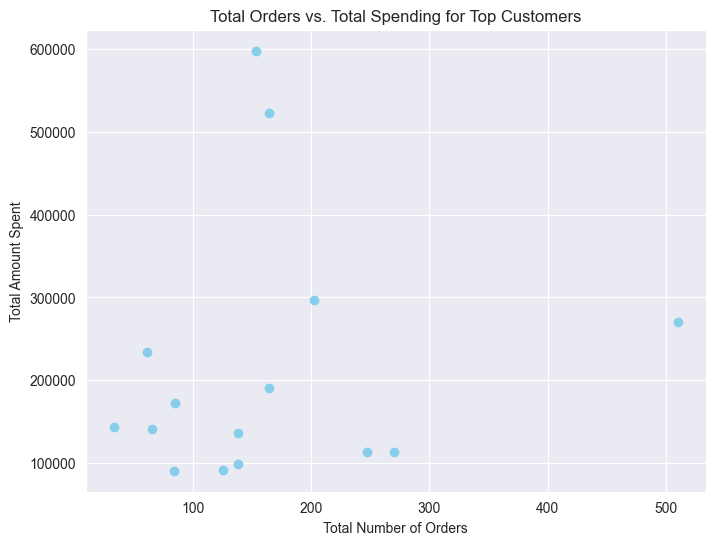

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(most_revenue_cus['total_orders'], most_revenue_cus['total_spent'], color='skyblue')
plt.xlabel('Total Number of Orders')
plt.ylabel('Total Amount Spent')
plt.title('Total Orders vs. Total Spending for Top Customers')
plt.grid(True)
plt.show()

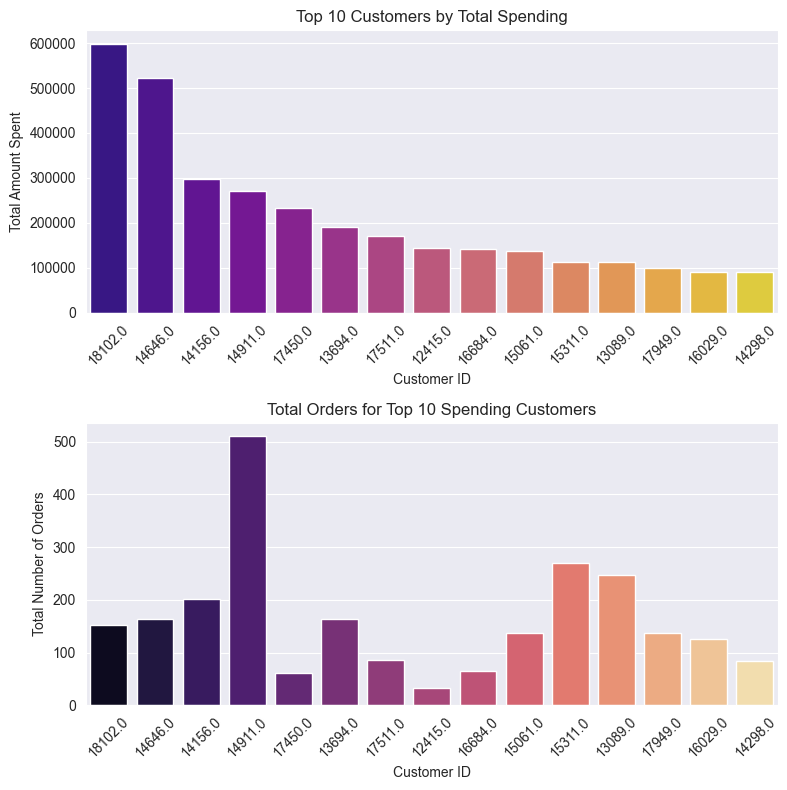

In [54]:
# 3. Subplots (Combining Total Spent and other metrics)
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

sns.barplot(x='customer_id', y='total_spent', data=most_revenue_cus, palette='plasma', ax=axes[0], hue = 'customer_id', legend = False)
axes[0].set_xlabel('Customer ID')
axes[0].set_ylabel('Total Amount Spent')
axes[0].set_title('Top 10 Customers by Total Spending')
axes[0].tick_params(axis='x', rotation=45, labelbottom=True)

sns.barplot(x='customer_id', y='total_orders', data=most_revenue_cus, palette='magma', ax=axes[1], hue = 'customer_id', legend = False)
axes[1].set_xlabel('Customer ID')
axes[1].set_ylabel('Total Number of Orders')
axes[1].set_title('Total Orders for Top 10 Spending Customers')
axes[1].tick_params(axis='x', rotation=45, labelbottom=True)

plt.tight_layout()
plt.show()

#### Top-10 selling products 

In [55]:
query = """
SELECT Description,
SUM(Quantity) AS total_quantity,
COUNT(TotalPrice) AS total_price
FROM sales_retail
GROUP BY Description
ORDER BY total_quantity DESC
LIMIT 10
"""

most_selling_prod = pd.read_sql_query(query, engine)
most_selling_prod

,description,total_quantity,total_price
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,108545,1056
1,WHITE HANGING HEART T-LIGHT HOLDER,93050,5918
2,ASSORTED COLOUR BIRD ORNAMENT,81306,2958
3,JUMBO BAG RED RETROSPOT,78090,3469
4,BROCADE RING PURSE,70700,483
5,PACK OF 60 PINK PAISLEY CAKE CASES,56575,2092
6,60 TEATIME FAIRY CAKE CASES,54366,2271
7,SMALL POPCORN HOLDER,49616,1562
8,PACK OF 72 RETROSPOT CAKE CASES,49344,1852
9,PACK OF 72 RETRO SPOT CAKE CASES,46106,1466


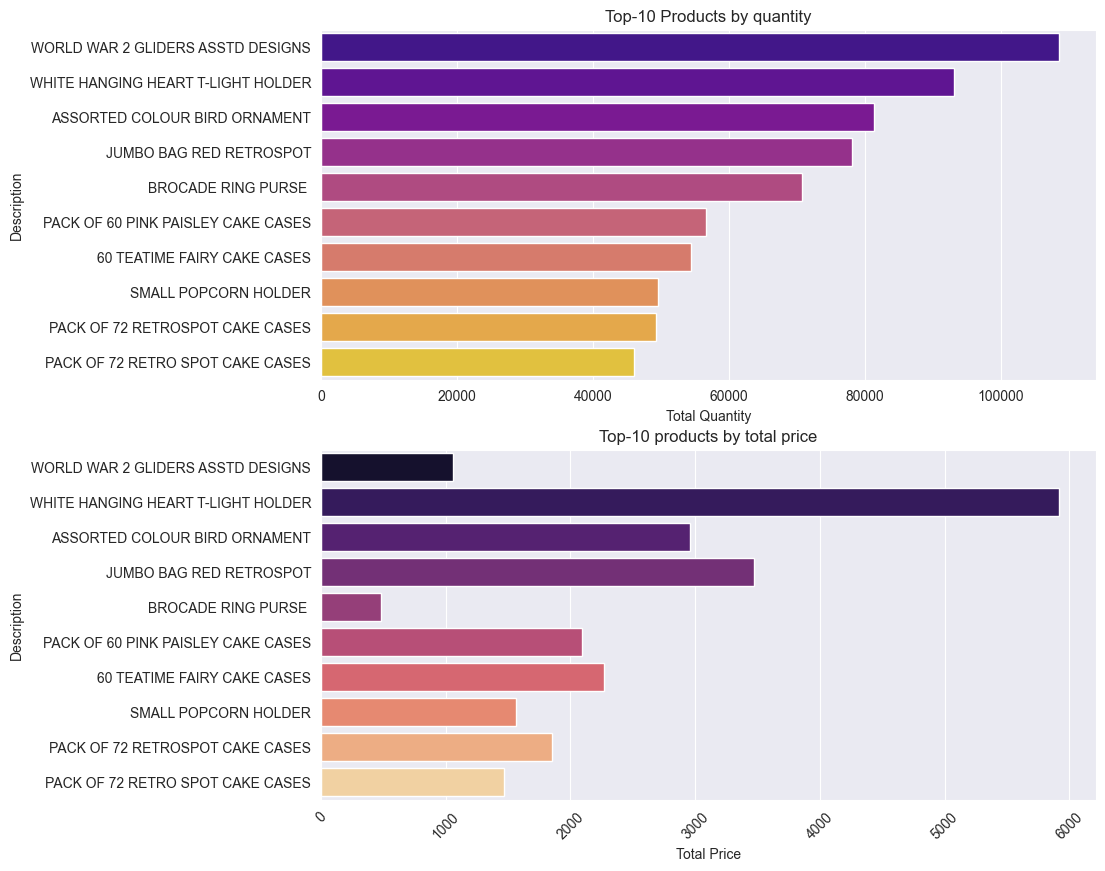

In [73]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(x = most_selling_prod['total_quantity'], y = most_selling_prod['description'],ax = axes[0], palette='plasma', hue=most_selling_prod['description'], legend=False)
axes[0].set_xlabel("Total Quantity")
axes[0].set_ylabel("Description")
axes[0].set_title("Top-10 Products by quantity")
axes[0].tick_params(axis='x', rotation=0, labelbottom=True)

sns.barplot(x = most_selling_prod['total_price'], y = most_selling_prod['description'],ax = axes[1], palette='magma', hue=most_selling_prod['description'], legend=False)
axes[1].set_xlabel("Total Price")
axes[1].set_ylabel("Description")
axes[1].set_title("Top-10 products by total price")
axes[1].tick_params(axis='x', rotation=45, labelbottom=True)

#### Hourly Sales trend

In [154]:
query = """
SELECT 
    EXTRACT(DAY FROM InvoiceDate) AS day,
    SUM(TotalPrice) AS revenue
FROM sales_retail
GROUP BY day
ORDER BY revenue DESC;
"""

daily_revenue = pd.read_sql_query(query, engine)
daily_revenue

,day,revenue
0,7.0,904469.06
1,8.0,849021.30
2,14.0,774415.20
3,15.0,761050.10
4,11.0,719727.60
5,9.0,696990.06
6,17.0,682070.75
7,4.0,676256.00
8,21.0,674407.56
9,1.0,666176.10


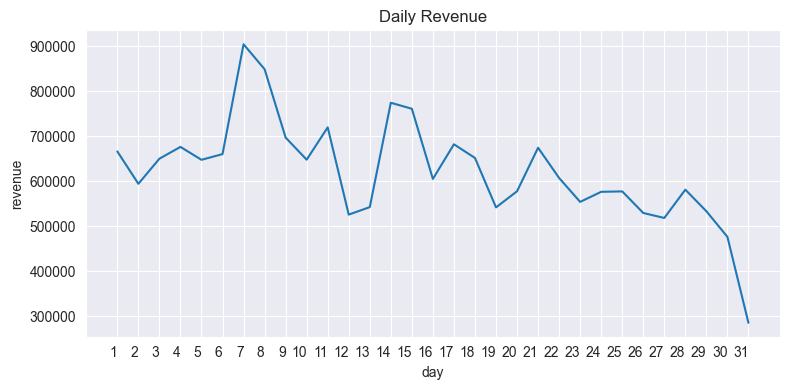

In [160]:
plt.figure(figsize=(8,4))
sns.lineplot(x = daily_revenue['day'], y = daily_revenue['revenue'])
plt.xticks(daily_revenue['day'], rotation=0, ha='right')
plt.title('Daily Revenue')
plt.tight_layout()
plt.grid(True)
plt.show()